In [2]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
data = pd.read_csv('data/occurrence_data.csv', delimiter='\t')
original_data = data.copy()
columns = data.columns

/tmp/ipykernel_746317/1039270105.py:1: DtypeWarning: Columns (45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/occurrence_data.csv', delimiter='\t')


In [3]:
data = data.loc[:,['gbifID', 'countryCode', 'locality',
       'stateProvince', 'decimalLatitude', 'decimalLongitude', 'elevation',
       'eventDate', 'day',
       'month', 'year']]
data = data.drop(15365)

In [4]:
nan_values = data[['day', 'month', 'year']].isna()
drop_nans = data[nan_values.any(axis=1)].index
data = data.drop(drop_nans)
date_columns = data.columns[-3:]
data[date_columns] = data[date_columns].astype(int)

In [5]:
data_loc_date = data[['decimalLatitude', 'decimalLongitude', 'day',
       'month', 'year']]
data_loc_date.columns = ['lat', 'lon', 'day',
       'month', 'year']
nan_vals = data_loc_date.isna()
drop_index = nan_vals[nan_vals.any(axis=1)].index
data_loc_date = data_loc_date.drop(drop_index)
data_loc_date = data_loc_date[data_loc_date['year']>=1960]


In [14]:
csv_out = data_loc_date.copy()
csv_out['id'] = csv_out.index +1
csv_out['date'] = csv_out['year'].astype(str) + '_' + csv_out['month'].astype(str) + '_' + csv_out['day'].astype(str)

In [23]:
csv_out = csv_out.drop(16645)

In [24]:
csv_out = csv_out[['lat', 'lon']]
csv_out.to_csv('points.csv')

In [6]:
base_dir = 'data/tifs'

tif_data = []

for dirpath, dirnames, filenames in os.walk(base_dir):
    for file in filenames:
        if file.endswith('.tif'):
            # Extract year and month from the filename
            year, month = file.split('_')[-1].split('.')[0].split('-')
            data_type = file.split('_')[-2]
            
            # Append to data list
            tif_data.append({
                'file_path': os.path.join(dirpath, file),
                'type': data_type,
                'year': int(year),
                'month': int(month)
            })

df_tifs = pd.DataFrame(tif_data)

df_tifs

,file_path,type,year,month
0,data/tifs/wc2.1_cruts4.06_2.5m_prec_1990-1999/...,prec,1998,2
1,data/tifs/wc2.1_cruts4.06_2.5m_prec_1990-1999/...,prec,1998,9
2,data/tifs/wc2.1_cruts4.06_2.5m_prec_1990-1999/...,prec,1993,9
3,data/tifs/wc2.1_cruts4.06_2.5m_prec_1990-1999/...,prec,1999,5
4,data/tifs/wc2.1_cruts4.06_2.5m_prec_1990-1999/...,prec,1996,4
...,...,...,...,...
2227,data/tifs/wc2.1_cruts4.06_2.5m_tmin_2000-2009/...,tmin,2001,5
2228,data/tifs/wc2.1_cruts4.06_2.5m_tmin_2000-2009/...,tmin,2003,1
2229,data/tifs/wc2.1_cruts4.06_2.5m_tmin_2000-2009/...,tmin,2005,12
2230,data/tifs/wc2.1_cruts4.06_2.5m_tmin_2000-2009/...,tmin,2001,2


In [6]:
import os
import rasterio
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the entire file into an array
        data_loc_date[column_name] = data_loc_date.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

# Assuming data_loc_date is your DataFrame with lat and lon
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers based on your CPU
    executor.map(process_file, all_files)

data_loc_date.to_csv('test2.csv')


['wc2.1_30s_bio_11.tif', 'wc2.1_30s_bio_3.tif', 'wc2.1_30s_bio_9.tif', 'wc2.1_30s_bio_13.tif', 'wc2.1_30s_bio_5.tif', 'wc2.1_30s_bio_6.tif', 'wc2.1_30s_elev.tif', 'wc2.1_30s_bio_17.tif', 'wc2.1_30s_bio_10.tif', 'wc2.1_30s_bio_2.tif', 'wc2.1_30s_bio_15.tif', 'wc2.1_30s_bio_12.tif', 'wc2.1_30s_bio_1.tif', 'wc2.1_30s_bio_16.tif', 'wc2.1_30s_bio_8.tif', 'wc2.1_30s_bio_4.tif', 'wc2.1_30s_bio_19.tif', 'wc2.1_30s_bio_7.tif', 'wc2.1_30s_bio_14.tif', 'wc2.1_30s_bio_18.tif']
Processing: bio_11

Processing: bio_3

Processing: bio_9

Processing: bio_13

Processing: bio_5

Processing: bio_6

Processing: elev

Processing: bio_17



: 

In [5]:
points = pd.read_csv('points.csv')
points = points.drop(columns=['Unnamed: 0'])


34.9625

In [7]:
eur_points = points[points['lon'] != -123.015953]

In [8]:
eur_points['lon'].min()

-7.537369

In [9]:
min_lat = eur_points['lat'].min()
max_lat = eur_points['lat'].max()
min_lon = eur_points['lon'].min()
max_lon = eur_points['lon'].max()

map_extent = [min_lon, max_lon, min_lat, max_lat]
map_extent

[-7.537369, 51.08368, 34.9625, 59.918117]

# Clustering

In [17]:
from sklearn.preprocessing import StandardScaler

In [29]:
bioclim = pd.read_csv('bioclim.csv')
bioclim = bioclim.drop(columns=['Unnamed: 0'])

In [30]:
coords = bioclim[['lat', 'lon']]
bioclim = bioclim.drop(columns=['lat', 'lon'])

In [31]:
bioclim = bioclim[bioclim['bio_13']!=-3.4e+38]

In [37]:
bioclim

,bio_13,bio_11,bio_9,bio_3,elev,bio_5,bio_6,bio_17,bio_10,bio_2,...,bio_12,bio_1,bio_16,bio_8,bio_4,bio_19,bio_7,bio_14,bio_18,ndvi
0,82.0,1.100000,2.116667,29.925650,199,24.6,-2.3,125.0,18.533333,8.050000,...,663.0,9.683333,230.0,18.533333,710.95750,132.0,26.9,36.0,230.0,0.157664
1,82.0,1.100000,2.116667,29.925650,199,24.6,-2.3,125.0,18.533333,8.050000,...,663.0,9.683333,230.0,18.533333,710.95750,132.0,26.9,36.0,230.0,0.157664
2,81.0,1.400000,2.483333,30.308643,117,24.9,-2.1,120.0,18.816666,8.183333,...,645.0,10.008333,227.0,18.816666,709.33014,125.0,27.0,35.0,227.0,0.151344
3,81.0,1.400000,2.483333,30.308643,117,24.9,-2.1,120.0,18.816666,8.183333,...,645.0,10.008333,227.0,18.816666,709.33014,125.0,27.0,35.0,227.0,0.151344
4,81.0,1.400000,2.483333,30.308643,117,24.9,-2.1,120.0,18.816666,8.183333,...,645.0,10.008333,227.0,18.816666,709.33014,125.0,27.0,35.0,227.0,0.151344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33061,64.0,2.066667,3.200000,33.012820,141,24.8,-1.2,120.0,18.416666,8.583333,...,593.0,10.075000,186.0,16.900000,664.93850,134.0,26.0,39.0,167.0,0.260822
33062,68.0,2.183333,3.383333,33.460560,99,25.1,-1.1,121.0,18.666666,8.766666,...,613.0,10.275000,198.0,17.100000,669.73030,133.0,26.2,39.0,177.0,0.192020
33063,68.0,2.183333,3.383333,33.460560,99,25.1,-1.1,121.0,18.666666,8.766666,...,613.0,10.275000,198.0,17.100000,669.73030,133.0,26.2,39.0,177.0,0.192020
33064,68.0,2.183333,3.383333,33.460560,99,25.1,-1.1,121.0,18.666666,8.766666,...,613.0,10.275000,198.0,17.100000,669.73030,133.0,26.2,39.0,177.0,0.192020


In [32]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(bioclim)

bioclim_scaled = pd.DataFrame(df_scaled, columns=bioclim.columns)


In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=2)  
pca.fit(bioclim_scaled)
df_pca = pca.transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_

print(df_pca)
print("Explained Variance Ratio:", explained_variance)


            PC1       PC2
0      5.766416  0.811498
1      5.766416  0.811498
2      6.022165  0.127403
3      6.022165  0.127403
4      6.022165  0.127403
...         ...       ...
32846  4.510245 -1.967747
32847  4.729919 -1.820823
32848  4.729919 -1.820823
32849  4.729919 -1.820823
32850  3.843480 -0.295435

[32851 rows x 2 columns]
Explained Variance Ratio: [0.31033347 0.26281878]


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


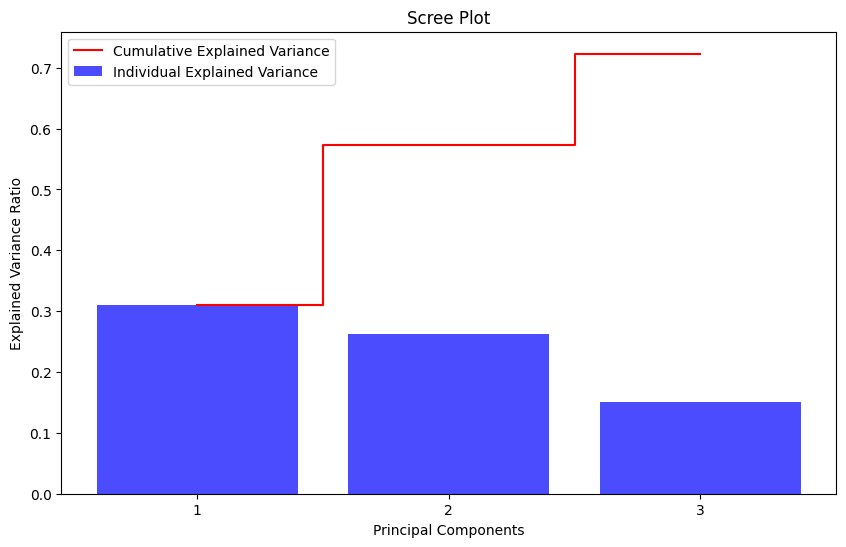

In [49]:
explained_variance = pca.explained_variance_ratio_

# Number of principal components
n_components = len(explained_variance)

# Creating the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, color='blue', label='Individual Explained Variance')
plt.step(range(1, n_components + 1), explained_variance.cumsum(), where='mid', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1)) # To show each component on the x-axis
plt.show()

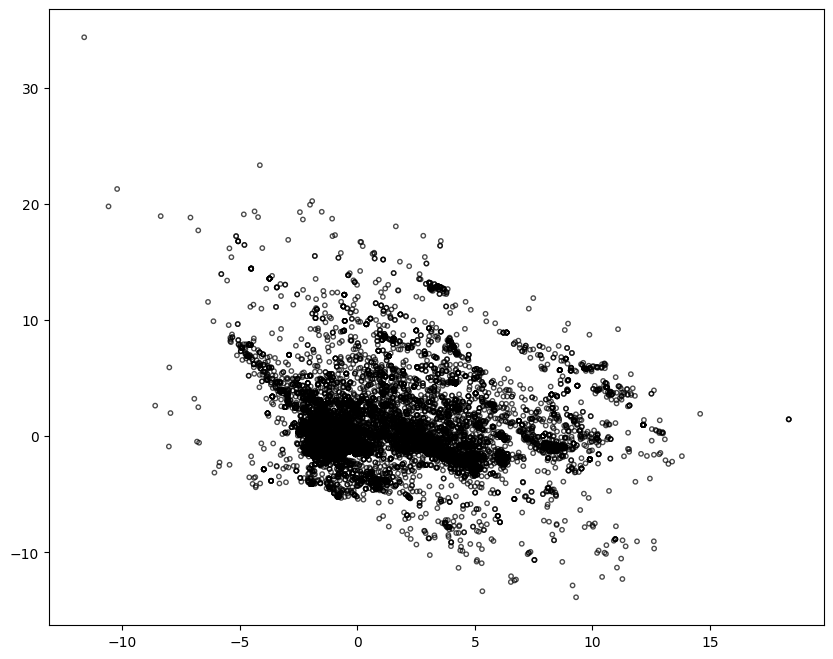

In [69]:
plt.figure(figsize=(10, 8))

plt.scatter(df_pca['PC1'], df_pca['PC2'], s=10, marker= 'o', facecolor='none', edgecolor='k', alpha=0.7)
# for idx, row in df_pca.iterrows():
#     plt.annotate(idx, (row['PC1'], row['PC2']), textcoords="offset points", xytext=(5,-5), ha='center')


In [56]:
points.loc[14961] ## left top anomaly location

lat    51.95
lon     4.35
Name: 14961, dtype: float64

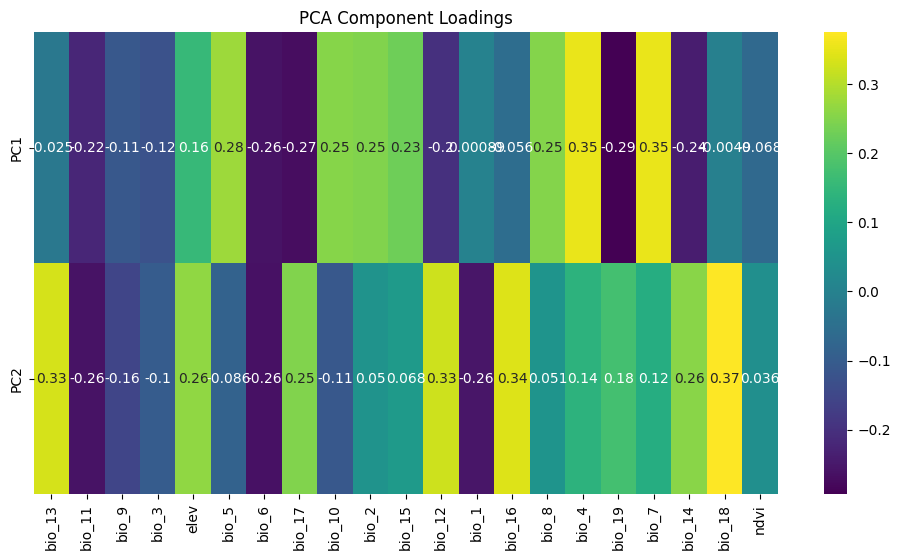

In [71]:
import seaborn as sns

loadings = pca.components_

df_loadings = pd.DataFrame(loadings, columns=bioclim.columns, index=[f'PC{i+1}' for i in range(len(loadings))])

# Visualizing the loadings with a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_loadings, annot=True, cmap='viridis')
plt.title('PCA Component Loadings')
plt.show()

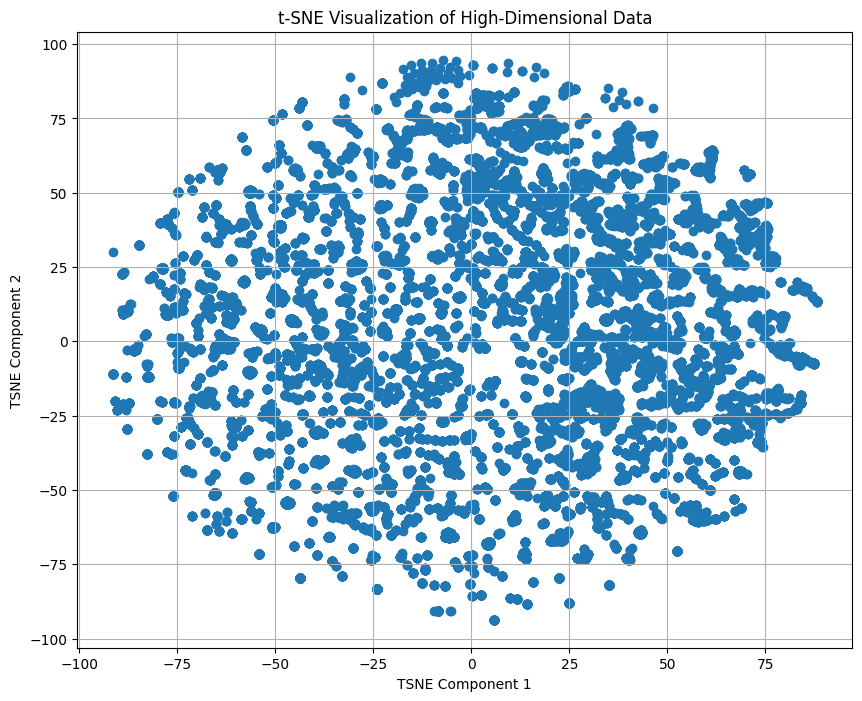

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

tsne_results = tsne.fit_transform(bioclim_scaled)
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])




In [ ]:
# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'])
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE Visualization of High-Dimensional Data')
plt.grid(True)
plt.show()

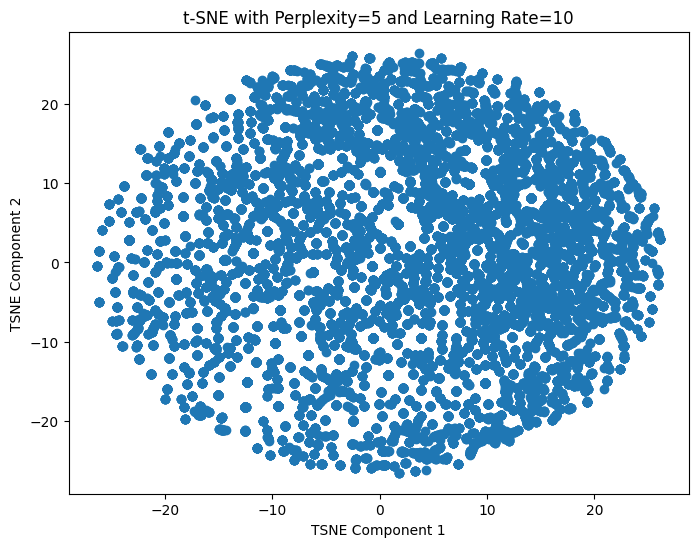

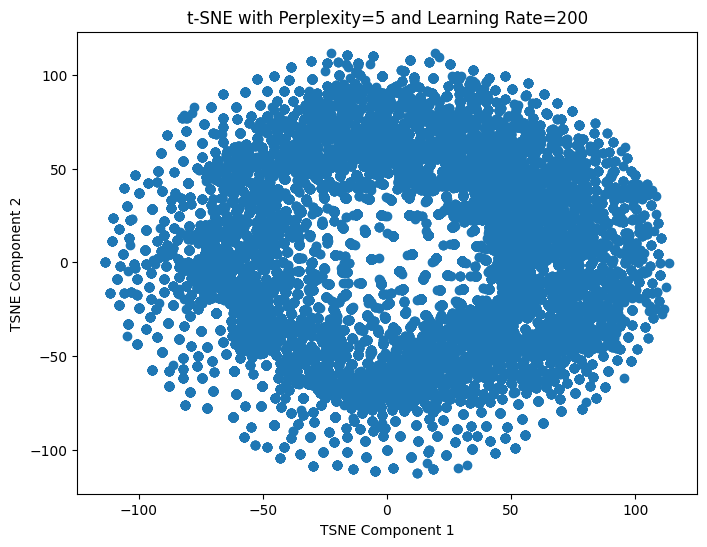

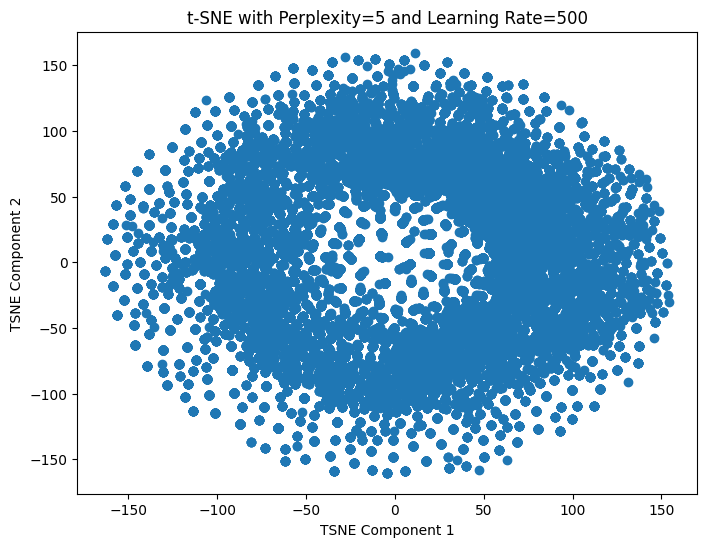

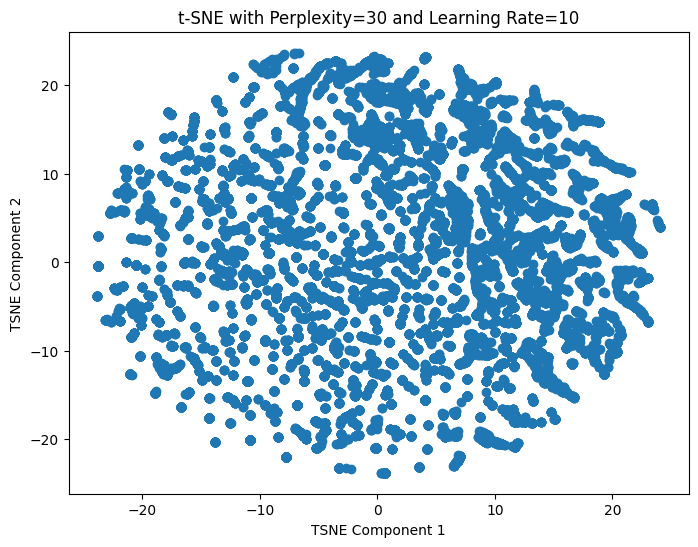

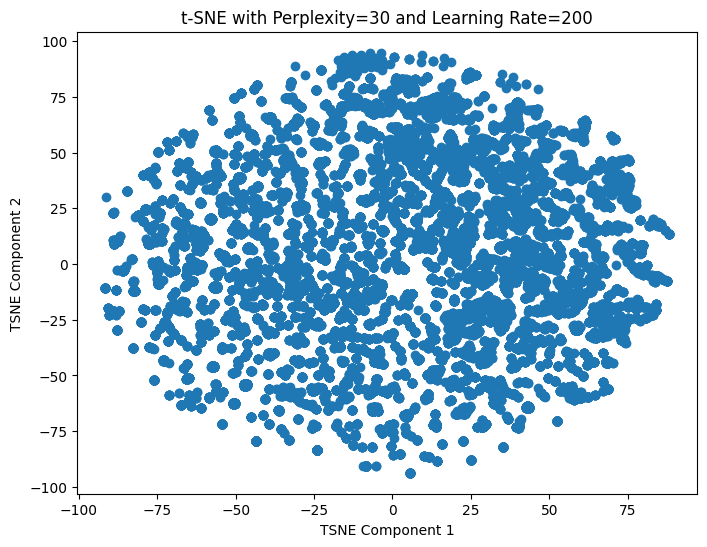

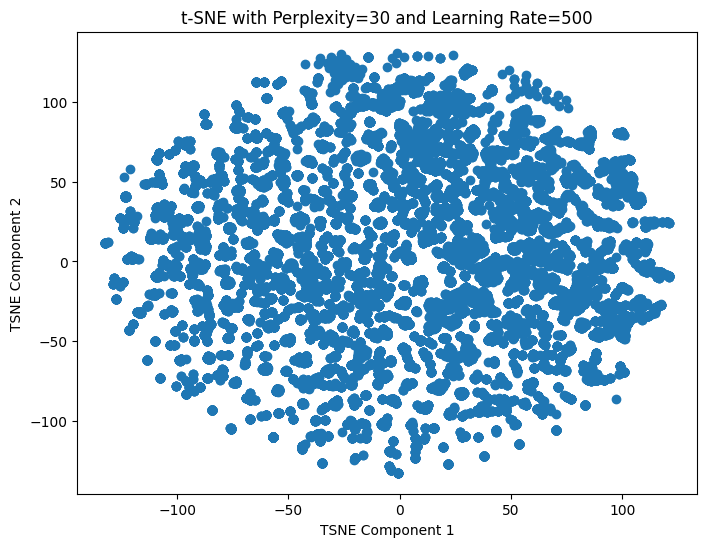

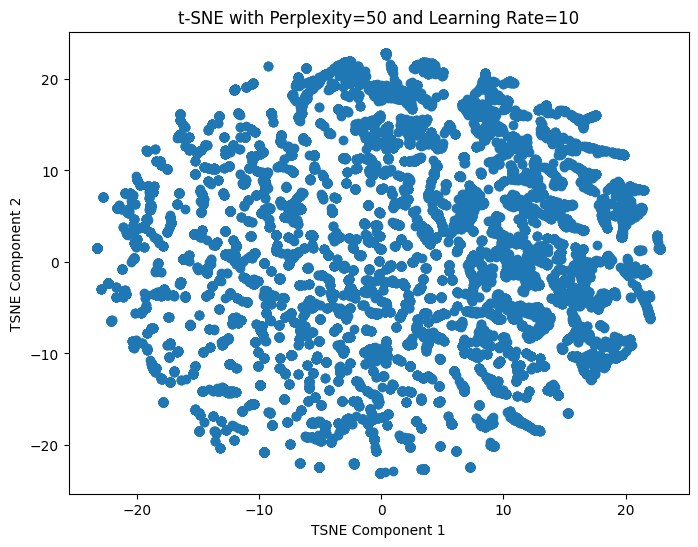

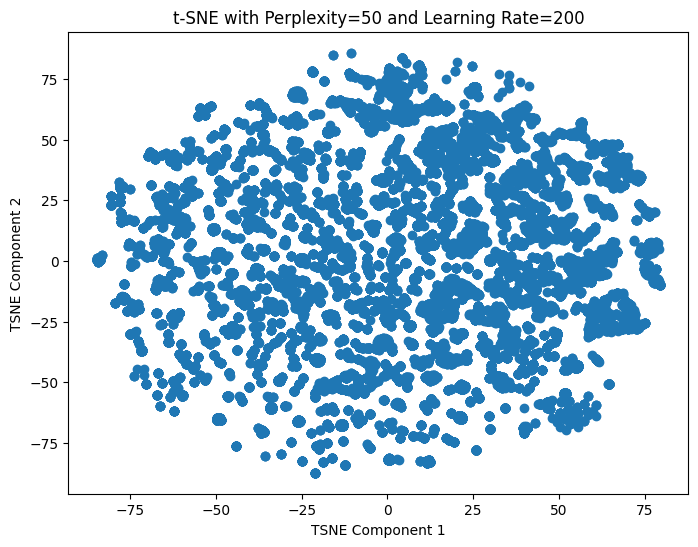

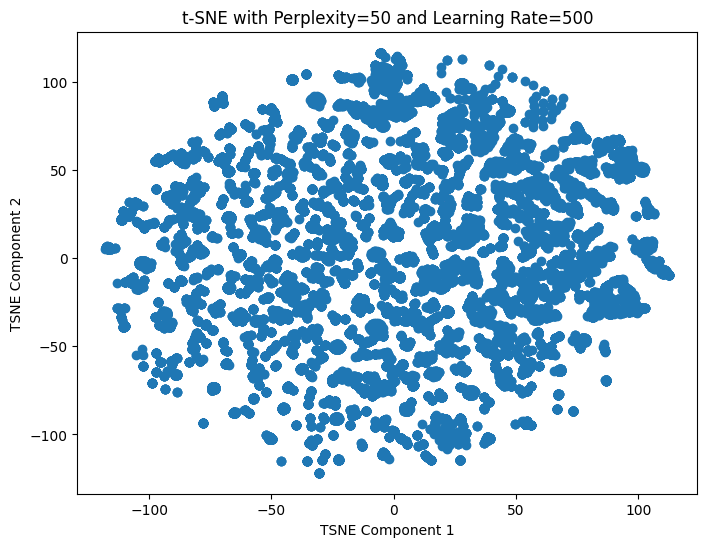

In [72]:

for perplexity in [5, 30, 50]:
    for learning_rate in [10, 200, 500]:
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
        tsne_results = tsne.fit_transform(bioclim_scaled)

        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
        plt.title(f't-SNE with Perplexity={perplexity} and Learning Rate={learning_rate}')
        plt.xlabel('TSNE Component 1')
        plt.ylabel('TSNE Component 2')
        plt.show()